# Imports

In [177]:
import math
import random
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
from torch.utils.data import DataLoader

from datasets import ModelnetDataset, ShapenetDataset, JointDataset
from transforms import SetRotation
from gmvae import GMVAE
from modelutils import cd

# Prepare dataset

In [96]:
modelnet_train = ModelnetDataset(filter=1)
modelnet_test = ModelnetDataset(filter=1, test=True)
modelnet_train_loader = DataLoader(modelnet_train, batch_size=32, shuffle=True, num_workers=2)
modelnet_test_loader = DataLoader(modelnet_test, batch_size=32, shuffle=True, num_workers=2)

shapenet_train = ShapenetDataset(filter=1, transform=SetRotation((0, math.acos(0), 0)))
shapenet_test = ShapenetDataset(filter=1, test=True, transform=SetRotation((0, math.acos(0), 0)))
shapenet_train_loader = DataLoader(shapenet_train, batch_size=32, num_workers=2)
shapenet_test_loader = DataLoader(shapenet_test, batch_size=32, shuffle=True, num_workers=2)

joint_train = JointDataset(filter=1, transform_shapenet=SetRotation((0, math.acos(0), 0)))
joint_test = JointDataset(filter=1, test=True, transform_shapenet=SetRotation((0, math.acos(0), 0)))
joint_train_loader = DataLoader(joint_train, batch_size=32, shuffle=True, num_workers=2)
joint_test_loader = DataLoader(joint_test, batch_size=32, shuffle=True, num_workers=2)

print(len(joint_train))

3943


# Load model

In [105]:
clusters = 10
prior_means = torch.tensor(np.load('saved_priors2.npy'))

In [106]:
model = GMVAE.load_from_drive(GMVAE, name='best_gmvae', clusters=clusters, prior_means=prior_means)

# Visualize clusters

In [99]:
def zzip(a, b):
    if len(a) == 0:
        if len(b) == 0:
            return []
        else:
            return b
    if len(b) == 0:
        return a
    return [a[0], b[0]] + zzip(a[1:], b[1:])

def unstack(t):
    return [x.squeeze(0) for x in list(t.split(1))]

In [100]:
def subplot_num(m, i, j):
    return i*m + j

def draw_pc(ax, pc):
    pc = SetRotation((np.pi/2, -np.pi, 0))(pc.detach().numpy())
    X, Y, Z = np.split(pc, 3)
    ax.scatter(X, Y, Z)

def plot_samples(samples, n, m, save=False, savename='pclouds'):
    fig = plt.figure(figsize=(4.5*m,4.5*n))
    fig.set_tight_layout(True)
    for i in range(n):
        for j in range(m):
            idx = subplot_num(m, i, j)
            ax = fig.add_subplot(n, m, idx+1, projection='3d', xticks=[], yticks=[], zticks=[])
            draw_pc(ax, samples[idx])    
    if save:
        plt.savefig(savename, bbox_inches='tight', pad_inches=0)
    plt.show()

In [ ]:
examples = [[] for i in range(clusters)]
with torch.no_grad():
    for x, _ in joint_train_loader:
        mx, idx = model.predict(x)
        for i in range(x.shape[0]):
            if mx[i] > 0.9:
                examples[idx[i]].append(x[i])
print(list(enumerate([len(c) for c in examples])))

/Users/kubaz/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


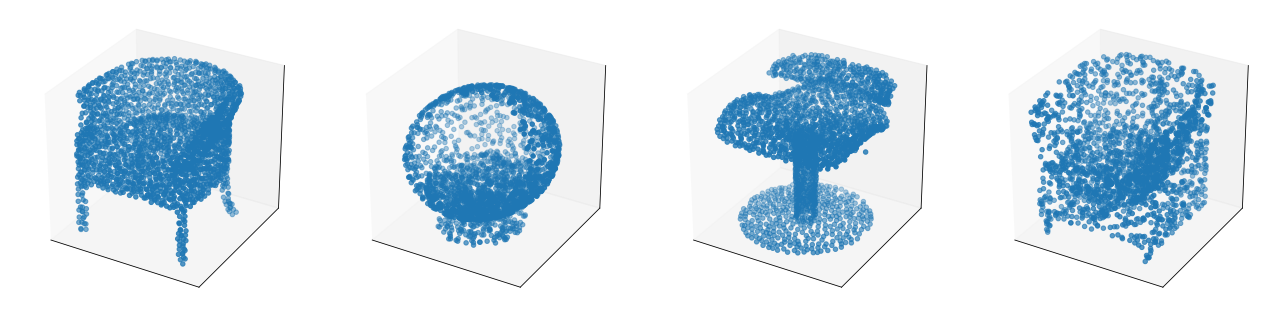

In [297]:
cnum = 5
selected = []
for i in range(4):
    selected.append(random.choice(examples[cnum]))
plot_samples(selected, 1, 4)

# Losowanie latentu

/Users/kubaz/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


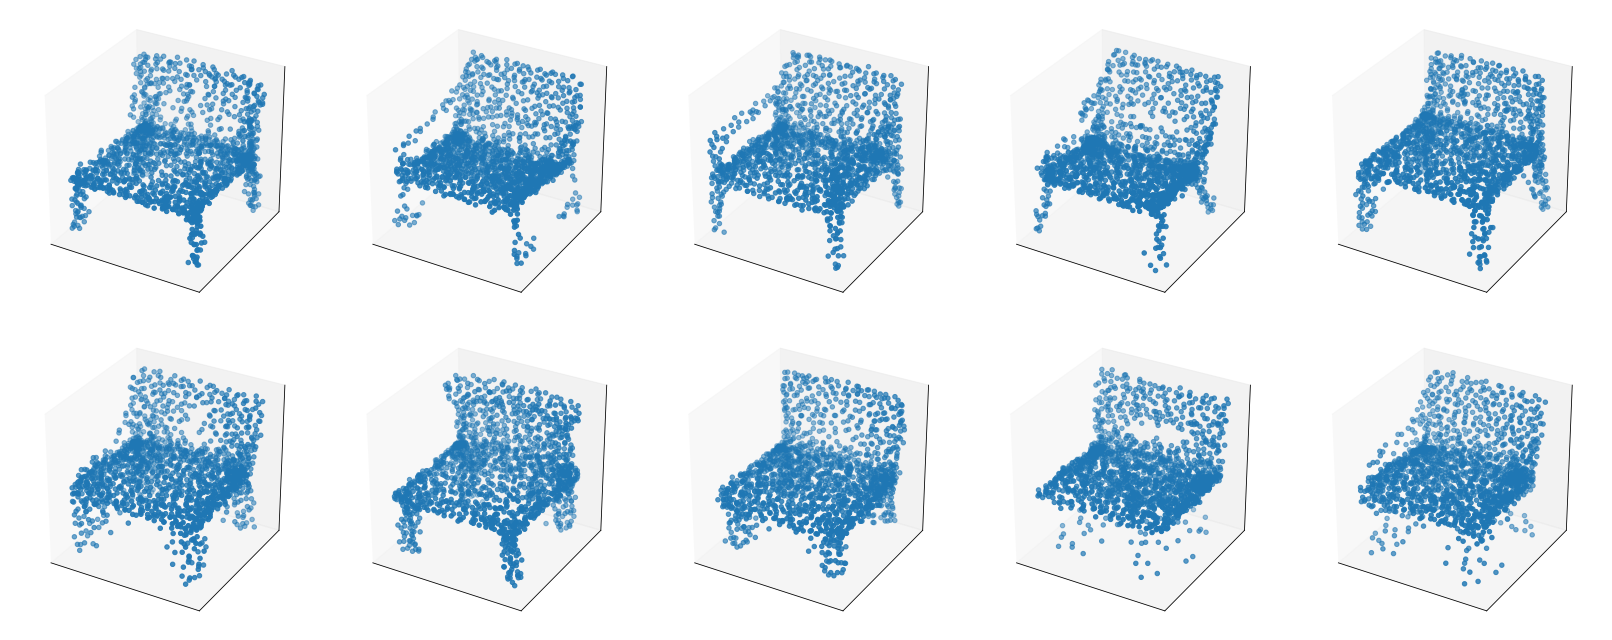

In [320]:
noise = 1.5*torch.randn_like(prior_means)
samples = model.decoder(noise+prior_means).reshape((-1,3,2048))
plot_samples(samples, 2, 5)

# Wykresy tSNE

In [5]:
with torch.no_grad():
    latents_list = [model.encode(x)[1] for x, _ in joint_train_loader]
latents = torch.cat(latents_list, dim=0).detach().numpy()

In [6]:
tsne = TSNE(n_components=2)
X, Y = tsne.fit_transform(latents).T

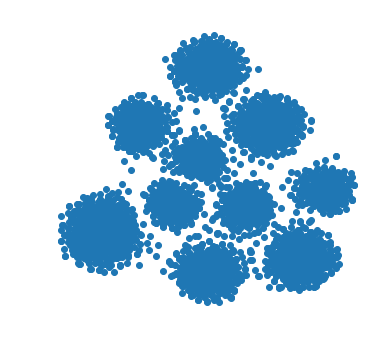

In [54]:
plt.figure(figsize=(6, 6))
# plt.axis('off')
plt.scatter(X, Y)
plt.show()

In [42]:
fx, tx = 15, 20
fy, ty = 20, 25
idxs = list(filter(lambda idx: X[idx] > fx and X[idx] < tx and Y[idx] > fy and Y[idx] < ty, range(X.shape[0])))
XY = np.stack((X, Y), axis=1)
XY[idxs]
selected_latents = torch.tensor(np.stack([latents[idxs[idx]] for idx in range(len(idxs))], axis=0))
selected_samples = model.decoder(selected_latents).reshape((-1,3,2048)).detach()
print(len(selected_samples))

58


/Users/kubaz/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


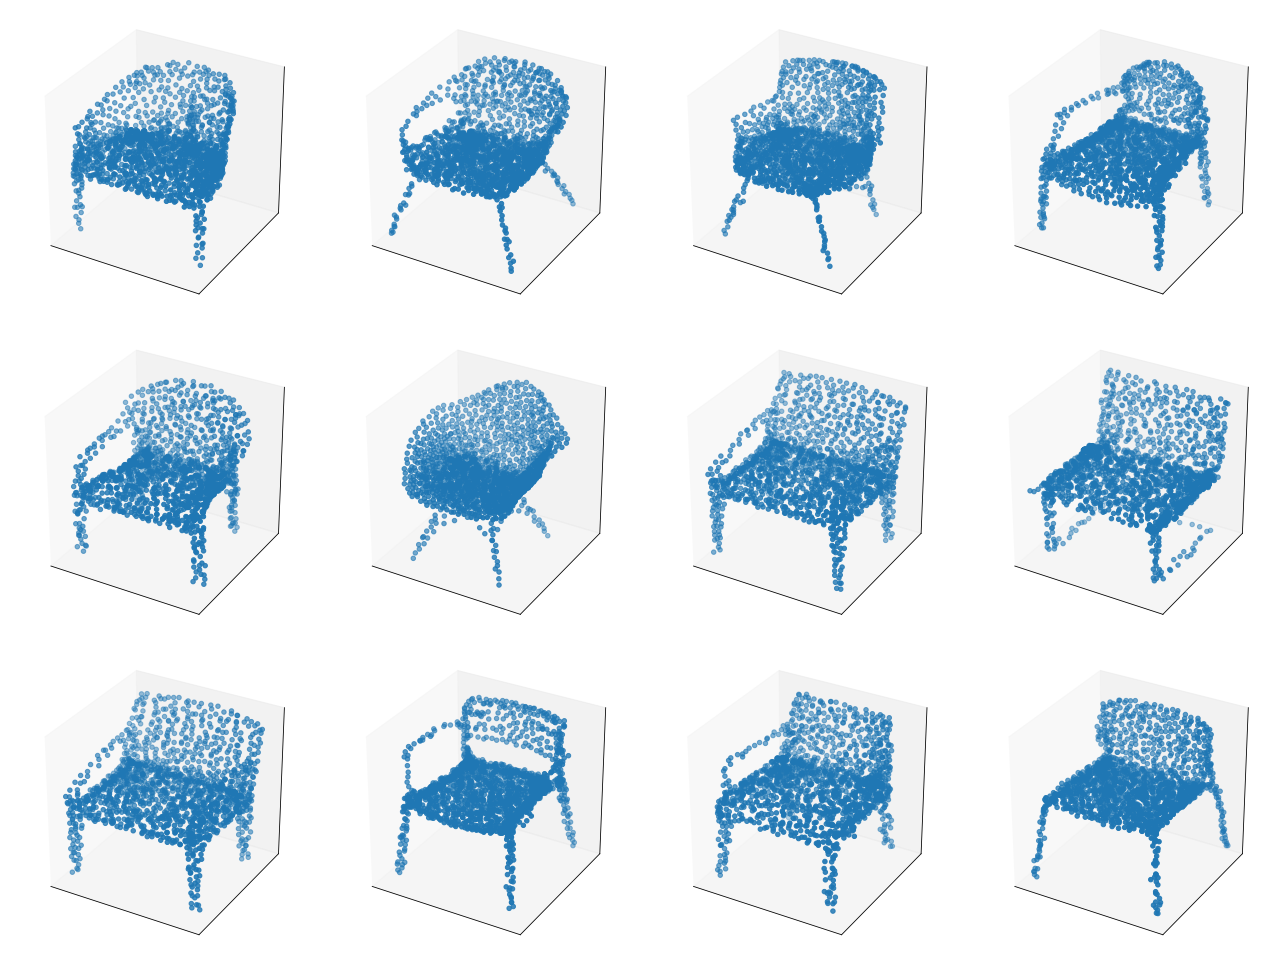

In [43]:
plot_samples(selected_samples, 3, 4)